# Crayon RAG-Based Chatbot System: RAG Chatbot Using ChromaDB, LlamaIndex, and Gradio

## Step 1: Environment Setup  

## Step 2: Data EDA (Exploratory Data Analysis)  
- **Load the data**  
- **Explore and analyze the data**  

## Step 3: Building the RAG System and Vector Database  
- **Chunk documents into nodes**  
- **Embed chunks into vectors and store them in the vector database using ChromaDB**  
- **Create a retriever with Chroma**  
- **Perform semantic search using the vector database**  

## Step 4: Building the RAG-Based Chatbot  
- **Develop a WebUI using Gradio**  
- **Integrate LLM function calls for query resolution**  

## Step 5: Model Evaluation  
- **Evaluate the LLM as a router**  
- **Assess the performance of the RAG system**  
- **Monitor and optimize performance**  

## Step 1: Environment Setup  

Configure the environment variables and python packages

In [1]:
# Importing necessary libraries
import os  # Provides functions to interact with the operating system
import json  # Provides methods to work with JSON data
import llama_index  # Library for building and querying LLM-based indices
import chromadb  # Vector database for efficient similarity search
import gradio as gr  # Library for building web-based user interfaces
from openai import OpenAI  # OpenAI library for using OpenAI's LLM APIs
from importlib.metadata import version  # For checking package versions

# Environment variable handling
from dotenv import load_dotenv, find_dotenv  # For loading environment variables from a .env file

# LlamaIndex components
from llama_index.embeddings.openai import OpenAIEmbedding  # Embedding model integration for OpenAI
# from llama_index.llms.openai import OpenAI  # Alternative LLM integration for OpenAI
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, StorageContext  # Core components for index management
from llama_index.core.settings import Settings  # LlamaIndex settings configuration
from llama_index.core.retrievers import VectorIndexRetriever  # Retriever for querying vector-based indices
from llama_index.core.node_parser import SimpleNodeParser  # Node parser for structuring data for indexing
from llama_index.vector_stores.chroma import ChromaVectorStore  # Chroma vector store integration for LlamaIndex

# Importing additional libraries
from sklearn.metrics import confusion_matrix  # For computing confusion matrices in evaluation
import numpy as np  # Numerical computation library

# Verify and display the versions of the LlamaIndex and chromadb libraries
print(f"LlamaIndex version: {version('llama_index')}")  # Outputs the installed version of LlamaIndex
print(f"chromadb version: {version('chromadb')}")  # Outputs the installed version of chromadb

# Load environment variables from a .env file if it exists
load_dotenv(find_dotenv())  # Searches for a .env file and loads its variables into the environment

# Configure settings for LlamaIndex
# Set the embedding model to use OpenAI's embeddings
Settings.embed_model = OpenAIEmbedding()
# You can uncomment the line below to set an LLM (e.g., GPT-3.5-Turbo) for use in LlamaIndex
# Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LlamaIndex version: 0.11.18
chromadb version: 0.5.16


## Step 2: Data EDA (Exploratory Data Analysis)  

- **Load the data**  
- **Explore and analyze the data**  

In [2]:
# Load data
documents = SimpleDirectoryReader("./dataset/policy").load_data()

## Step 3: Building the RAG System and Vector Database  
- **Chunk documents into nodes**  
- **Embed chunks into vectors and store them in the vector database using ChromaDB**  
- **Create a retriever with Chroma**  
- **Perform semantic search using the vector database**  

### Step 3.1 : **Chunk documents into nodes**  

As the whole document is too large to fit into the context window of the LLM, you will need to partition it into smaller text chunks, which are called Nodes in LlamaIndex.

With the SimpleNodeParser each document is stored as chunks. Each chunk consists of 258 tokens. Different chunks are overlapeed with each other.

In [3]:
# Initialize a node parser with default settings and custom chunking parameters
# The 'chunk_size' parameter defines the maximum size of each document chunk in terms of tokens or characters.
# The 'chunk_overlap' parameter specifies the number of overlapping tokens/characters between consecutive chunks.
# This overlap ensures contextual continuity between chunks, which can improve the performance of downstream LLM queries.
node_parser = SimpleNodeParser.from_defaults(chunk_size=258, chunk_overlap=50)

# Parse the documents into smaller chunks (nodes) based on the defined chunking parameters
# 'documents' is expected to be a list of document objects (e.g., text, metadata) that needs to be split.
# The 'get_nodes_from_documents' method applies the parser's logic to break the input documents into nodes.
# Each node represents a structured chunk of data that can be indexed for retrieval or further processing.
nodes = node_parser.get_nodes_from_documents(documents)

### Step 3.2: **Embed chunks into vectors and store them in the vector database using ChromaDB**  

In [ ]:
# Initialize the Chroma database client
# 'PersistentClient' sets up a persistent database for storing embeddings and metadata.
# The 'path' parameter specifies the directory where the database files will be saved.
db = chromadb.PersistentClient(path="./dataset/chroma_db")

# Create or access a collection within the Chroma database
# A collection is a logical grouping of embeddings and metadata.
# If the collection "policy_knowledge" does not exist, it will be created.
chroma_collection = db.get_or_create_collection("policy_knowledge")

# Assign Chroma as the vector store for the storage context
# ChromaVectorStore is integrated with the Chroma database collection.
# This vector store will manage the storage and retrieval of embeddings.
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# Create a storage context using the vector store
# The 'StorageContext' provides a unified interface to interact with the vector store during indexing and retrieval.
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Build a VectorStoreIndex
# The 'VectorStoreIndex' handles:
# 1. Chunking documents into nodes
# 2. Encoding those chunks into embeddings using the configured embedding model
# 3. Storing the embeddings in the vector store for efficient retrieval
# The 'nodes' parameter contains the parsed document chunks created earlier.
# The 'storage_context' links the index to the Chroma vector store for embedding storage and query retrieval.
index = VectorStoreIndex(nodes, storage_context=storage_context)


### Step 3.3: **Create a retriever with Chroma**  
creata a retriever to support allows for semantic search

First, initialize the PersistentClient with the same path you specified while creating the Chroma vector store. You'll then retrieve the collection "policy_knowledge" you created previously from Chroma. You can use this collection to initialize the ChromaVectorStore in which you store the embeddings of the website data. You can then use the from_vector_store function of VectorStoreIndex to load the index.

In [5]:
# Initialize a Chroma database client for loading persisted data
# 'PersistentClient' is used to access the database stored at the specified path.
# The 'path' parameter should match the location where the database was previously saved.
load_client = chromadb.PersistentClient(path="./dataset/chroma_db")

# Retrieve an existing collection from the Chroma database
# The 'get_collection' method fetches the collection "policy_knowledge" that contains stored embeddings and metadata.
# This assumes the collection was previously created and populated with data.
chroma_collection = load_client.get_collection("policy_knowledge")

# Recreate the vector store from the fetched collection
# ChromaVectorStore provides an interface to the Chroma collection, allowing embedding storage and retrieval.
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# Reconstruct the index from the vector store
# 'from_vector_store' initializes a new VectorStoreIndex using the pre-existing vector store.
# This enables seamless retrieval and query functionality without re-indexing the original documents.
index = VectorStoreIndex.from_vector_store(vector_store)

### Step 3.4: **Perform semantic search using the vector database**  

In [6]:
# Function to fetch an external policy knowledge response based on a query
def get_external_policy_knowledge(query):
    """
    This function performs semantic search to find relevant chunks
    and generates a response using a Large Language Model (LLM).

    Parameters:
    query (str): The input query to search for relevant knowledge.

    Returns:
    str: The LLM-generated response based on the retrieved knowledge.
    """
    # Create a query engine from the index to enable semantic search
    test_query_engine = index.as_query_engine()

    # Query the index and fetch the response
    # This uses semantic similarity to retrieve relevant chunks and passes them to the LLM.
    response = test_query_engine.query(query)

    # Convert the response to a string for consistent serialization
    return str(response)


# Test the query semantic search and fetch a response using the OpenAI GPT-3.5 model
print(get_external_policy_knowledge("Tell me about the government financial policy"))


# Function to retrieve the most relevant chunk for a given query
def get_relevant_chunks(query):
    """
    This function performs semantic search to find the most relevant chunk for the given query.

    Parameters:
    query (str): The input query to search for relevant knowledge.

    Returns:
    str: The text content of the most relevant chunk.
    """
    # Initialize a retriever from the vector index with similarity-based retrieval
    # 'similarity_top_k=1' ensures only the most relevant chunk is retrieved.
    retriever = VectorIndexRetriever(index=index, similarity_top_k=1)

    # Retrieve the nodes (chunks) matching the query
    nodes = retriever.retrieve(query)

    # Return the text content of the first (most relevant) chunk
    return nodes[0].text

The Model Governance Policy outlines the guiding principles and procedures for the governance of artificial intelligence (AI) model development, deployment, and monitoring within the organization. It aims to ensure that AI models operate effectively, ethically, and in compliance with all applicable regulations, safeguarding technological innovations, upholding ethical commitments, and maintaining stakeholder trust.


## Step 4: Building the RAG-Based Chatbot  
- **Develop a WebUI using Gradio**  
- **Integrate LLM function calls for query resolution**  

Building RAG based ChatBot with WebUI and LLM function calling
 - Use the LLM with function calling as the router to support multi-turn conversation
 - Build the WebUI via gradio as a prototype
 - gpt-4 as the LLM router
 - gpt-3.5-turbo is the answer summarizer to summarize the query and extracted text chunks

In [7]:
# Define the function schema for OpenAI API integration
functions = [
    {
        "name": "get_external_policy_knowledge",  # Name of the function being defined
        "description": (
            "Retrieve knowledge from external policy documents. "
            "This documents database consists of Data Privacy Policy, AI Ethics Policy, and Model Governance Policy."
        ),  # Describes the function's purpose and the database it accesses
        "parameters": {
            "type": "object",  # Specifies that the parameters should be an object
            "properties": {  # Defines the structure of the expected object
                "query": {
                    "type": "string",  # The query parameter must be a string
                    "description": "The query to search for in the policy documents"  # Explains the purpose of the query parameter
                }
            },
            "required": ["query"]  # Indicates that the 'query' field is mandatory
        }
    }
]

In [8]:
# Initialize the OpenAI client with the API key from environment variables
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def predict(message, history):
    """
    Predicts the response to a user's message by leveraging OpenAI's GPT model. 
    The function integrates function calls to fetch external knowledge when needed.

    Parameters:
    message (str): The current user message.
    history (list of tuples): The chat history, where each tuple contains (user_message, assistant_message).

    Returns:
    str: The assistant's response.
    """
    # Format the chat history for OpenAI API
    history_openai_format = [
        {
            "role": "system",
            "content": (
                "You are an AI assistant. Only answer the question based on the chat history or "
                "information extracted from the external database. Do not answer questions based on your own knowledge."
            )
        }
    ]
    # Append past user and assistant messages to the formatted history
    for human, assistant in history:
        history_openai_format.append({"role": "user", "content": human})
        history_openai_format.append({"role": "assistant", "content": assistant})
    # Append the current user message
    history_openai_format.append({"role": "user", "content": message})

    # Use the LLM to decide whether to directly respond or call a function for additional information
    response = client.chat.completions.create(
        model='gpt-4',  # Specify the GPT model to use
        messages=history_openai_format,  # Provide the formatted chat history
        functions=functions,  # Provide the function schema for potential function calls
        function_call="auto",  # Allow the model to decide whether to call a function
        temperature=0.1  # Control randomness in the model's response
    )

    # Extract the model's response
    response_message = response.choices[0].message

    # Check if the model wants to call a function
    if response_message.function_call:
        # Extract the name and arguments of the requested function
        function_name = response_message.function_call.name
        function_args = json.loads(response_message.function_call.arguments)

        # Handle the specific function call
        if function_name == "get_external_policy_knowledge":
            # Fetch knowledge using the specified function
            function_response = get_external_policy_knowledge(function_args.get("query"))
            print(function_response)  # Debugging output

            return function_response  # Return the function's response directly
    else:
        # If no function call is requested, return the model's direct response
        return response_message.content


# Create and launch a Gradio WebUI interface using the predict function
gr.ChatInterface(predict).launch()

/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/gradio/components/chatbot.py:228: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.


## Step 5: Model Evaluation  
### Eval 1: **Evaluate the LLM as a router**  
 - confusion matrix

 - **Test data**: both in-domain and out of domain question

### Eval 2: **Assess the performance of the RAG system** 
 - Accuracy
    - BLEU or ROUGE
 - Faithfulness
    - RAG retriever relevance
 - Latency 
    - LLM response time
    - RAG responses time

### Eval 3: **Monitor and optimize performance**  
  - monitor the whole system performance



### Prepare dataset for testing

Manully provide several test cases with corresponding answers:
In the test datset, we provides 5 test cases, which consists of 
- In-domian questions 
- Irrelevant question 
- Out of distribution questions

In [9]:
# Define a list of labeled test cases for validating the assistant's responses
labeled_text_cases = [
    # In-domain questions related to data policy, AI ethics policy, and model governance policy
    {
        # Data Privacy Policy Question
        "text": "Where should the data be stored.",
        "expected_answer": (
            "Data is securely stored in state-of-the-art data centers located in the United States, the European Union, "
            "and other jurisdictions, depending on the nature of the data and the services provided. Each location is chosen "
            "based on stringent security standards and data protection compliance."
        ),
        "label": "function_call"  # Indicates that a function call should be used to fetch the response
    },
    {
        # AI Ethics Policy Question
        "text": "Tell me about the AI Transparency rules.",
        "expected_answer": (
            "Enhance transparency by developing interfaces that allow users to query AI decisions and receive explanations "
            "in understandable terms. Document all AI systems decision-making processes and methodologies, ensuring that this "
            "documentation is accessible to all relevant stakeholders and regularly updated."
        ),
        "label": "function_call"  # Indicates a function call is needed to retrieve this response
    },
    {
        # Model Governance Policy Question
        "text": "How to test and validate the model?",
        "expected_answer": (
            "Models must undergo rigorous testing to validate their accuracy, performance, and fairness. Validation tests should "
            "be designed to cover various operational scenarios and should include stress and failure mode analysis. "
            "Documentation of all test results is mandatory for auditability and further review."
        ),
        "label": "function_call"  # Indicates this response should be fetched through a function call
    },

    # Out-of-distribution (OOD) questions
    {
        # Question unrelated to in-domain policies
        "text": "Tell me about the Australia financial regulation",
        "expected_answer": "I cannot answer this question",  # Direct answer without function call
        "label": "direct_answer"
    },

    # Irrelevant questions
    {
        # General greeting question
        "text": "Hi.",
        "expected_answer": "Hello, what can I help you today",  # Simple direct response
        "label": "direct_answer"  # Indicates no function call is required
    }
]


### Step 5.1:  **Evaluate the LLM as a router**  

    Check if the LLM can call the RAG system precisely.

In [10]:

# Initialize the OpenAI client with the API key from environment variables
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def indicator_call_RAG(query):
    """
    Determines whether a query requires a direct answer or a function call to fetch relevant knowledge.
    If unsure, the model is encouraged to avoid providing incorrect responses to avoid user misinformation.

    Parameters:
    query (str): The user's query.

    Returns:
    str: "function_call" if a function call is needed, otherwise "direct_answer".
    """
    # Define the system prompt to guide the model's behavior
    history_openai_format = [
        {
            "role": "system",
            "content": (
                "You are a policy documents assistant, and you are responsible to answer company data privacy, "
                "AI ethics, and data governance policy questions. Providing no response is more acceptable than offering "
                "an incorrect one, as the latter could mislead the user regarding their query."
            )
        }
    ]
    # Append the user's query to the chat history
    history_openai_format.append({"role": "user", "content": query})

    # Use the LLM to determine whether to directly answer or call a function for additional information
    response = client.chat.completions.create(
        model='gpt-4',  # Specify the GPT model to use
        messages=history_openai_format,  # Provide the chat history
        functions=functions,  # Provide the function schema for potential calls
        function_call="auto",  # Allow the model to decide whether to call a function
        temperature=0  # Set temperature to 0 for deterministic responses
    )

    # Extract the model's response message
    response_message = response.choices[0].message

    # Check if the model has requested a function call
    if response_message.function_call:
        return "function_call"  # Indicate that a function call is required
    else:
        return "direct_answer"  # Indicate that a direct answer is sufficient

# Iterate through labeled test cases and predict labels using the indicator_call_RAG function
for item in labeled_text_cases:
    item["predicted_label"] = indicator_call_RAG(item["text"])  # Add the predicted label to each test case


In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Extract the true labels (ground truth) and predicted labels
y_true = [item['label'] for item in labeled_text_cases]  # Ground truth labels from the test cases
y_pred = [item['predicted_label'] for item in labeled_text_cases]  # Predicted labels from the model

# Calculate the confusion matrix
# 'labels' ensures that the confusion matrix includes all possible labels, even if not present in predictions or ground truth.
labels = list(set(y_true + y_pred))  # Collect unique labels from both true and predicted values
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a pandas DataFrame for better visualization of the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Print the confusion matrix in DataFrame format
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
               direct_answer  function_call
direct_answer              1              1
function_call              0              3


### Step 5.2: **Assess the performance of the RAG system** 
 - Accuracy
   - BLEU or ROUGE
 - Faithfulness
 - RAG retriever relevance
 - Latency 
    - LLM response time
    - RAG responses time

 - **Test data:** in-domain question which is relevant to the documents

In [12]:
from sentence_transformers import SentenceTransformer, util  # For embedding-based semantic similarity
import numpy as np  # For numerical operations like mean
import time  # To measure latency
from rouge import Rouge  # For evaluating text similarity (ROUGE metric)
from nltk.translate.bleu_score import sentence_bleu  # For BLEU score evaluation of text similarity

# Load the embedding model
# 'all-MiniLM-L6-v2' is a lightweight SentenceTransformer model optimized for semantic similarity tasks.
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def evaluate_rag_system_with_semantics(labeled_text_cases):
    """
    Evaluate the RAG system using various metrics, including accuracy, faithfulness, retriever relevance, and latency.

    Metrics:
    - Accuracy: BLEU and ROUGE scores to evaluate response quality against the expected answers.
    - Faithfulness: Semantic similarity between retrieved chunks and the LLM's response.
    - RAG retriever relevance: Checks if the retrieved chunks are relevant to the expected answers.
    - Latency: Measures the time taken by the retriever and the LLM to generate responses.

    Args:
        labeled_text_cases (list): A list of test cases containing queries, expected answers, and labels.

    Returns:
        dict: Evaluation results, including accuracy, faithfulness, retriever relevance, and latency metrics.
    """
    # Initialize metrics dictionary
    metrics = {
        "accuracy": {"bleu": [], "rouge": []},  # Store BLEU and ROUGE scores for accuracy
        "faithfulness": [],  # Semantic similarity between retrieved chunks and LLM response
        "retriever_relevance": [],  # Boolean relevance scores for retriever output
        "latency": {"retriever_time": [], "llm_time": []},  # Time measurements for retriever and LLM
    }

    # Initialize ROUGE scorer
    rouge = Rouge()

    # For demonstration, limit the number of test cases (optional)
    labeled_text_cases = labeled_text_cases[:3]

    # Loop through each labeled test case
    for case in labeled_text_cases:
        query = case["text"]  # User's query
        expected_answer = case["expected_answer"]  # Expected response

        # Measure retriever latency
        retriever_start = time.time()
        retrieved_chunks = get_relevant_chunks(query)  # Retrieve relevant chunks
        retriever_end = time.time()
        metrics["latency"]["retriever_time"].append(retriever_end - retriever_start)

        # Measure LLM latency
        llm_start = time.time()
        llm_response = get_external_policy_knowledge(query)  # Generate response using LLM
        llm_end = time.time()
        metrics["latency"]["llm_time"].append(llm_end - llm_start)

        # Evaluate Accuracy: BLEU and ROUGE scores
        bleu_score = sentence_bleu([expected_answer.split()], llm_response.split())  # Compute BLEU score
        rouge_scores = rouge.get_scores(llm_response, expected_answer, avg=True)  # Compute ROUGE scores
        metrics["accuracy"]["bleu"].append(bleu_score)
        metrics["accuracy"]["rouge"].append(rouge_scores)

        # Evaluate Faithfulness: Semantic similarity between retrieved chunks and LLM response
        retrieved_embedding = embedding_model.encode(retrieved_chunks, convert_to_tensor=True)  # Encode retrieved chunks
        llm_response_embedding = embedding_model.encode(llm_response, convert_to_tensor=True)  # Encode LLM response
        faithfulness_score = util.pytorch_cos_sim(retrieved_embedding, llm_response_embedding).item()  # Compute similarity
        metrics["faithfulness"].append(faithfulness_score)

        # Evaluate Retriever Relevance: Check if retrieved chunks are relevant to the expected answer
        retriever_relevance = retrieved_chunks in expected_answer  # Boolean check
        metrics["retriever_relevance"].append(retriever_relevance)

    # Summarize results by calculating averages
    results = {
        "accuracy": {
            "avg_bleu": sum(metrics["accuracy"]["bleu"]) / len(metrics["accuracy"]["bleu"]),  # Average BLEU score
            "avg_rouge": {
                key: sum([score[key]["f"] for score in metrics["accuracy"]["rouge"]]) / len(metrics["accuracy"]["rouge"])
                for key in ["rouge-1", "rouge-2", "rouge-l"]  # Average ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
            },
        },
        "faithfulness": np.mean(metrics["faithfulness"]),  # Average semantic similarity
        "retriever_relevance": sum(metrics["retriever_relevance"]) / len(metrics["retriever_relevance"]),  # Proportion of relevant chunks
        "latency": {
            "avg_retriever_time": sum(metrics["latency"]["retriever_time"]) / len(metrics["latency"]["retriever_time"]),  # Average retriever latency
            "avg_llm_time": sum(metrics["latency"]["llm_time"]) / len(metrics["latency"]["llm_time"]),  # Average LLM latency
        },
    }

    return results

# Example usage: Evaluate the RAG system and print the results
results = evaluate_rag_system_with_semantics(labeled_text_cases)
print("Evaluation Results:")
print(f"{results}")

/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 cou

Evaluation Results:
{'accuracy': {'avg_bleu': 0.6449922429023552, 'avg_rouge': {'rouge-1': 0.7232323184045204, 'rouge-2': 0.6587547251475764, 'rouge-l': 0.7098989850711871}}, 'faithfulness': 0.6428516109784445, 'retriever_relevance': 0.0, 'latency': {'avg_retriever_time': 3.354621966679891, 'avg_llm_time': 1.3133163452148438}}


In [14]:
def format_results_as_table(results):
    """
    Format the RAG evaluation results into a table using Pandas DataFrame for better readability.

    Args:
        results (dict): The evaluation results as a dictionary with metrics and values.

    Returns:
        pd.DataFrame: A formatted table of results as a Pandas DataFrame.
    """
    # Define a flat structure for the results with metric names and corresponding values
    table_data = {
        "Metric": [
            "BLEU",  # BLEU score for text accuracy
            "ROUGE-1",  # ROUGE-1 score for unigrams
            "ROUGE-2",  # ROUGE-2 score for bigrams
            "ROUGE-L",  # ROUGE-L score for longest common subsequences
            "Faithfulness",  # Semantic similarity between retrieved chunks and LLM response
            "Retriever Relevance",  # Proportion of relevant retrieved chunks
            "Avg Retriever Time (s)",  # Average retriever response time
            "Avg LLM Time (s)"  # Average LLM response time
        ],
        "Value": [
            results["accuracy"]["avg_bleu"],  # Average BLEU score
            results["accuracy"]["avg_rouge"]["rouge-1"],  # Average ROUGE-1 score
            results["accuracy"]["avg_rouge"]["rouge-2"],  # Average ROUGE-2 score
            results["accuracy"]["avg_rouge"]["rouge-l"],  # Average ROUGE-L score
            results["faithfulness"],  # Faithfulness score
            results["retriever_relevance"],  # Retriever relevance score
            results["latency"]["avg_retriever_time"],  # Average retriever latency in seconds
            results["latency"]["avg_llm_time"]  # Average LLM latency in seconds
        ]
    }

    # Create a DataFrame using the table data
    df_results = pd.DataFrame(table_data)
    return df_results

# Format the evaluation results into a table
df_evaluation_results = format_results_as_table(results)

# Display the results as a DataFrame
df_evaluation_results

,Metric,Value
0,BLEU,0.644992
1,ROUGE-1,0.723232
2,ROUGE-2,0.658755
3,ROUGE-L,0.709899
4,Faithfulness,0.642852
5,Retriever Relevance,0.000000
6,Avg Retriever Time (s),3.354622
7,Avg LLM Time (s),1.313316


## Step 5.3:  **Monitor and optimize performance**  
 - Logging performance metrics
 - Add time stamp 
 - Visulize the performance with time
 - Setup alert 

Metrics: {'accuracy': 0.8333333333333334, 'precision': 0.8888888888888888, 'recall': 0.8333333333333334, 'f1_score': 0.8380952380952381}


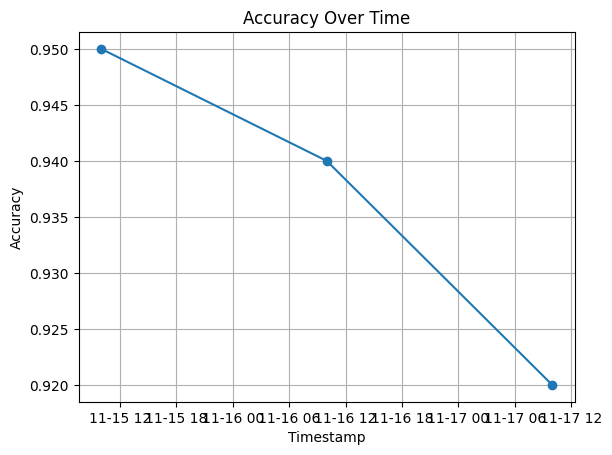

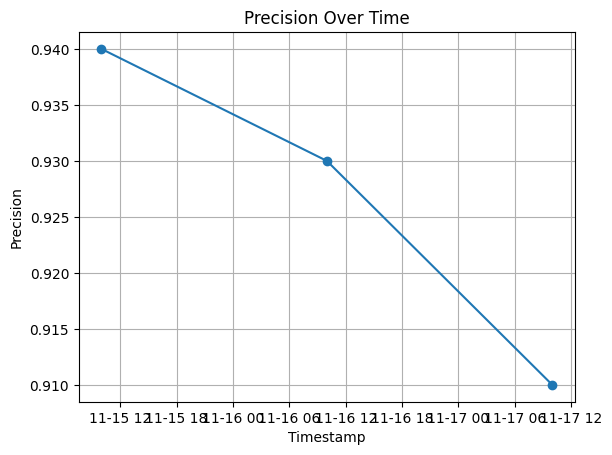

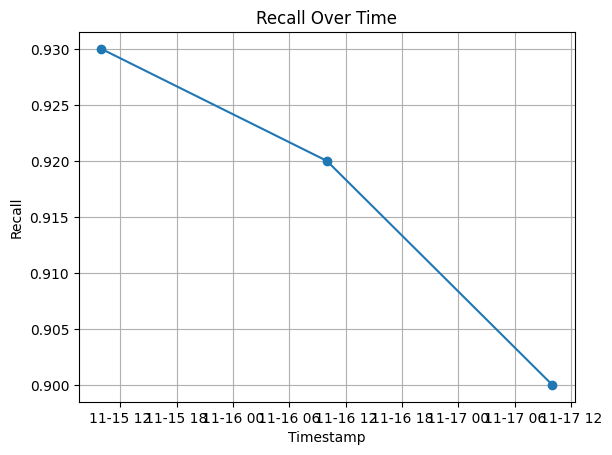

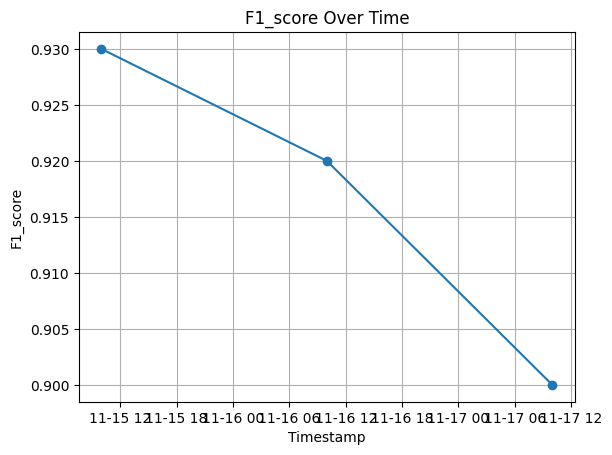

In [16]:
import pandas as pd  # For handling data and creating DataFrames
import matplotlib.pyplot as plt  # For visualizing metrics over time
from datetime import datetime  # For timestamps in logging
import logging  # For logging events and metrics

# Initialize logging for monitoring events
logging.basicConfig(filename="model_monitoring.log", level=logging.INFO)  # Logs are saved in "model_monitoring.log"

def log_event(event_type, message):
    """
    Log events related to model monitoring and evaluation.

    Args:
        event_type (str): Type of event (e.g., "INFO", "WARNING", "ERROR").
        message (str): Message describing the event.
    """
    # Create a timestamp for the log entry
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    # Log the event with the timestamp and message
    logging.info(f"[{timestamp}] [{event_type}] {message}")


def monitor_model_performance(real_data, predictions):
    """
    Monitor and evaluate model performance using various metrics.

    Args:
        real_data (list): Ground truth values (actual labels).
        predictions (list): Model's predictions.

    Returns:
        dict: A dictionary containing evaluation metrics (accuracy, precision, recall, F1 score).
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Importing metrics

    # Calculate performance metrics
    accuracy = accuracy_score(real_data, predictions)  # Proportion of correct predictions
    precision = precision_score(real_data, predictions, average='weighted')  # Precision considers false positives
    recall = recall_score(real_data, predictions, average='weighted')  # Recall considers false negatives
    f1 = f1_score(real_data, predictions, average='weighted')  # F1 is the harmonic mean of precision and recall

    # Log the calculated metrics
    log_event("INFO", f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    # Return metrics as a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

def visualize_metrics(metrics):
    """
    Visualize metrics over time for continuous monitoring.

    Args:
        metrics (dict): A dictionary of metrics with timestamps.
    """
    # Convert the metrics dictionary into a Pandas DataFrame
    df = pd.DataFrame(metrics)
    # Convert the "timestamp" column to datetime objects for proper plotting
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Plot each metric over time
    for metric in ["accuracy", "precision", "recall", "f1_score"]:
        plt.figure()  # Create a new figure for each metric
        plt.plot(df["timestamp"], df[metric], marker='o')  # Plot metric values with markers
        plt.title(f"{metric.capitalize()} Over Time")  # Set title with metric name
        plt.xlabel("Timestamp")  # Label for x-axis
        plt.ylabel(metric.capitalize())  # Label for y-axis
        plt.grid(True)  # Enable grid for better readability
        plt.show()  # Display the plot

def setup_alerts(thresholds):
    """
    Set up alerts for thresholds on metrics.

    Args:
        thresholds (dict): Threshold values for metrics.
    """
    # Define a nested function to check thresholds against metrics
    def check_thresholds(metrics):
        for metric, value in thresholds.items():
            if metrics[metric] < value:  # If a metric is below its threshold
                log_event("WARNING", f"{metric} below threshold: {metrics[metric]} < {value}")  # Log a warning
    return check_thresholds  # Return the nested function

# Example usage of the functions
# Ground truth labels and model predictions (sample data)
real_data = [1, 0, 1, 1, 0, 1]
predictions = [1, 0, 1, 0, 0, 1]

# Monitor model performance and print metrics
metrics = monitor_model_performance(real_data, predictions)
print("Metrics:", metrics)

# Historical metrics data for visualization
historical_metrics = [
    {"timestamp": "2024-11-15 10:00", "accuracy": 0.95, "precision": 0.94, "recall": 0.93, "f1_score": 0.93},
    {"timestamp": "2024-11-16 10:00", "accuracy": 0.94, "precision": 0.93, "recall": 0.92, "f1_score": 0.92},
    {"timestamp": "2024-11-17 10:00", "accuracy": 0.92, "precision": 0.91, "recall": 0.90, "f1_score": 0.90},
]

# Visualize metrics over time
visualize_metrics(historical_metrics)

# Set up thresholds for alerting
thresholds = {"accuracy": 0.90, "precision": 0.90, "recall": 0.90, "f1_score": 0.90}
alert_checker = setup_alerts(thresholds)

# Check the current metrics against thresholds and log warnings if needed
alert_checker(metrics)